In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import math,random
# Import Keras libraries
from tensorflow.python import keras
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# Import CF Model Architecture
from CFModel import CFModel
sns.set_style('white')
%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [7]:
df = pd.read_csv('new_ratings.csv', sep=',')
df.head()

FileNotFoundError: File b'new_ratings.csv' does not exist

In [3]:
movie = pd.read_csv("new_movies.csv")
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
new_df = pd.merge(df,movie,on='movieId')
new_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama


In [5]:
n_users = new_df.userId.max()
n_items = new_df.movieId.max()
print("Unique users are {} and unique movies are {}".format(n_users,n_items))

Unique users are 671 and unique movies are 9123


In [6]:
new_df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Fireworks Wednesday (Chaharshanbe-soori) (2006)    5.0
Son of Frankenstein (1939)                         5.0
Flicka (2006)                                      5.0
Caveman (1981)                                     5.0
Willie & Phil (1980)                               5.0
Name: rating, dtype: float64

In [7]:
new_df.groupby('title')['rating'].count().sort_values(ascending=False).head()


title
Forrest Gump (1994)                          341
Pulp Fiction (1994)                          324
Shawshank Redemption, The (1994)             311
Silence of the Lambs, The (1991)             304
Star Wars: Episode IV - A New Hope (1977)    291
Name: rating, dtype: int64

In [8]:
ratings = pd.DataFrame(new_df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
"""Great Performances"" Cats (1998)",1.750000
$9.99 (2008),3.833333
'Hellboy': The Seeds of Creation (2004),2.000000
'Neath the Arizona Skies (1934),0.500000
'Round Midnight (1986),2.250000


In [9]:
ratings['num of ratings'] = pd.DataFrame(new_df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
"""Great Performances"" Cats (1998)",1.750000,2
$9.99 (2008),3.833333,3
'Hellboy': The Seeds of Creation (2004),2.000000,1
'Neath the Arizona Skies (1934),0.500000,1
'Round Midnight (1986),2.250000,2


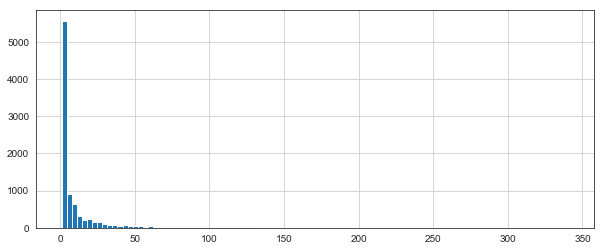

In [10]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=100)

In [5]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

NameError: name 'ratings' is not defined

<Figure size 720x288 with 0 Axes>

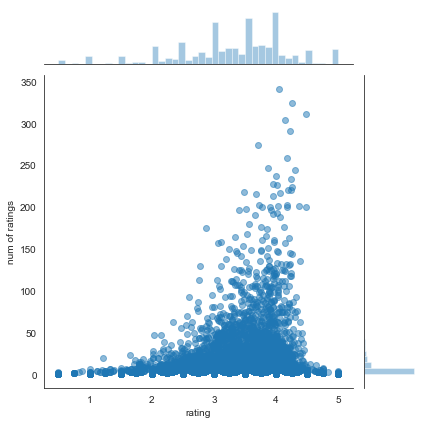

In [12]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)


In [13]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(new_df, test_size=0.25)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((671, 9123))
for data in train_data.itertuples():
    train_data_matrix[int(data[1])-1, int(data[2])-1] = float(data[3])  

test_data_matrix = np.zeros((671, 9123))
for data in test_data.itertuples():
    test_data_matrix[int(data[1])-1, int(data[2])-1] = float(data[3])

In [14]:
def predict1(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [15]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
item_prediction = predict1(train_data_matrix, item_similarity, type='item')
user_prediction = predict1(train_data_matrix, user_similarity, type='user')
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.361769500171521
Item-based CF RMSE: 3.5735826346153106


In [16]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 10)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 3.0402125140927883


In [17]:
import pandas
import os
import zipfile
import requests
import tqdm
from sklearn import dummy, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras


In [18]:
new_df.movieId = new_df.movieId.astype('category')
new_df.userId = new_df.userId.astype('category')
movieid = new_df.movieId.cat.codes.values
userid = new_df.userId.cat.codes.values
y = np.zeros((new_df.shape[0], 5))
int_rating= new_df.rating.astype('int')
y[np.arange(new_df.shape[0]), int_rating - 1] = 1

In [19]:
pred = dummy.DummyClassifier(strategy='prior')
pred.fit(new_df[['userId', 'movieId']], new_df.rating)
print(sqrt(mean_squared_error(new_df.rating, pred.predict(new_df[['userId', 'movieId']]))))

1.1522819879255357


In [20]:
# Now, the deep learning classifier
from keras.layers import concatenate
# First, we take the movie and vectorize it.
# The embedding layer is normally used for sequences (think, sequences of words)
# so we need to flatten it out.
# The dropout layer is also important in preventing overfitting
movie_input = keras.layers.Input(shape=[1])
movie_vec = keras.layers.Flatten()(keras.layers.Embedding(int(n_items) + 1, 32)(movie_input))
movie_vec = keras.layers.Dropout(0.5)(movie_vec)

# Same thing for the users
user_input = keras.layers.Input(shape=[1])
user_vec = keras.layers.Flatten()(keras.layers.Embedding(int(n_users) + 1, 32)(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)

# Next, we join them all together and put them
# through a pretty standard deep learning architecture
input_vecs = concatenate([movie_vec, user_vec])
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(input_vecs))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(nn))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = keras.layers.Dense(5, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = kmodels.Model([movie_input, user_input], result)
model.compile('adam', 'categorical_crossentropy')

# If we wanted to inspect part of the model, for example, to look
# at the movie vectors, here's how to do it. You don't need to 
# compile these models unless you're going to train them.
final_layer = kmodels.Model([movie_input, user_input], nn)
movie_vec = kmodels.Model(movie_input, movie_vec)

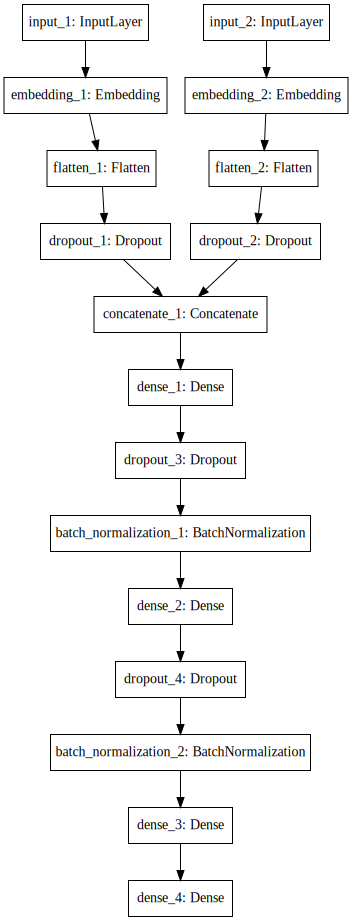

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        291968      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 32)        21504       input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 

In [24]:
a_movieid, b_movieid, a_userid, b_userid, a_y, b_y = train_test_split(movieid, userid, y)

In [25]:
# And of _course_ we need to make sure we're improving, so we find the MAE before
# training at all.
sqrt(mean_squared_error(np.argmax(b_y, 1)+1, np.argmax(model.predict([b_movieid, b_userid]), 1)+1))

1.8223869820800969

In [26]:
try:
    history = model.fit([a_movieid, a_userid], a_y, 
                         nb_epoch=20, 
                         validation_data=([b_movieid, b_userid], b_y))
    plot(history.history['loss'])
    plot(history.history['val_loss'])
except KeyboardInterrupt:
    pass

D:\Anaconda3\envs\kerasenv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 75006 samples, validate on 25002 samples
Epoch 1/20
75006/75006 [==============================] - ETA: 49:44 - loss: 2.23 - ETA: 5:43 - loss: 2.0574 - ETA: 3:08 - loss: 1.941 - ETA: 2:07 - loss: 1.858 - ETA: 1:38 - loss: 1.808 - ETA: 1:20 - loss: 1.763 - ETA: 1:11 - loss: 1.733 - ETA: 1:02 - loss: 1.715 - ETA: 55s - loss: 1.694 - ETA: 50s - loss: 1.67 - ETA: 46s - loss: 1.66 - ETA: 43s - loss: 1.65 - ETA: 40s - loss: 1.64 - ETA: 38s - loss: 1.63 - ETA: 36s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 33s - loss: 1.60 - ETA: 31s - loss: 1.59 - ETA: 30s - loss: 1.59 - ETA: 29s - loss: 1.58 - ETA: 28s - loss: 1.58 - ETA: 27s - loss: 1.58 - ETA: 26s - loss: 1.57 - ETA: 26s - loss: 1.57 - ETA: 25s - loss: 1.57 - ETA: 24s - loss: 1.57 - ETA: 24s - loss: 1.56 - ETA: 23s - loss: 1.56 - ETA: 23s - loss: 1.56 - ETA: 22s - loss: 1.55 - ETA: 22s - loss: 1.55 - ETA: 21s - loss: 1.55 - ETA: 21s - loss: 1.55 - ETA: 21s - loss: 1.55 - ETA: 20s - loss: 1.54 - ETA: 20s - loss: 1.54 - ETA: 20s -

75006/75006 [==============================] - ETA: 21s - loss: 1.22 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 12s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.27 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.26 - ETA: 11s - loss: 1.27 - ETA: 11s - loss: 

58432/75006 [======================>.......] - ETA: 22s - loss: 1.01 - ETA: 14s - loss: 1.19 - ETA: 16s - loss: 1.22 - ETA: 15s - loss: 1.23 - ETA: 15s - loss: 1.21 - ETA: 15s - loss: 1.22 - ETA: 15s - loss: 1.22 - ETA: 15s - loss: 1.22 - ETA: 14s - loss: 1.22 - ETA: 14s - loss: 1.22 - ETA: 14s - loss: 1.21 - ETA: 14s - loss: 1.21 - ETA: 14s - loss: 1.20 - ETA: 14s - loss: 1.21 - ETA: 14s - loss: 1.21 - ETA: 14s - loss: 1.21 - ETA: 14s - loss: 1.21 - ETA: 13s - loss: 1.21 - ETA: 13s - loss: 1.21 - ETA: 13s - loss: 1.21 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.19 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.19 - ETA: 13s - loss: 1.19 - ETA: 13s - loss: 1.20 - ETA: 13s - loss: 1.20 - ETA: 12s - loss: 1.20 - ETA: 12s - loss: 1.20 - ETA: 12s - loss: 1.20 - ETA: 12s - loss: 

75006/75006 [==============================] - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.222 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.222 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1.221 - ETA: 5s - loss: 1

62432/75006 [=======================>......] - ETA: 29s - loss: 1.12 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.17 - ETA: 18s - loss: 1.18 - ETA: 18s - loss: 1.16 - ETA: 18s - loss: 1.15 - ETA: 19s - loss: 1.16 - ETA: 19s - loss: 1.16 - ETA: 19s - loss: 1.17 - ETA: 19s - loss: 1.17 - ETA: 19s - loss: 1.17 - ETA: 18s - loss: 1.18 - ETA: 18s - loss: 1.18 - ETA: 18s - loss: 1.18 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 18s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 1.18 - ETA: 17s - loss: 1.18 - ETA: 17s - loss: 1.19 - ETA: 17s - loss: 

75006/75006 [==============================] - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 3s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 2s - loss: 1.194 - ETA: 1s - loss: 1.194 - ETA: 1s - loss: 1.194 - ETA: 1s - loss: 1.194 - ETA: 1s - loss: 1.193 - ETA: 1s - loss: 1.193 - ETA: 1s - loss: 1.193 - ETA: 1s - loss: 1

75006/75006 [==============================] - ETA: 20s - loss: 1.01 - ETA: 14s - loss: 1.15 - ETA: 14s - loss: 1.15 - ETA: 13s - loss: 1.17 - ETA: 15s - loss: 1.17 - ETA: 14s - loss: 1.16 - ETA: 14s - loss: 1.16 - ETA: 14s - loss: 1.16 - ETA: 14s - loss: 1.15 - ETA: 13s - loss: 1.16 - ETA: 13s - loss: 1.16 - ETA: 13s - loss: 1.16 - ETA: 13s - loss: 1.16 - ETA: 13s - loss: 1.16 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 1.15 - ETA: 12s - loss: 

75006/75006 [==============================] - ETA: 19s - loss: 1.01 - ETA: 14s - loss: 1.15 - ETA: 14s - loss: 1.15 - ETA: 13s - loss: 1.17 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 14s - loss: 1.13 - ETA: 14s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.13 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.15 - ETA: 13s - loss: 1.14 - ETA: 13s - loss: 

75006/75006 [==============================] - ETA: 16s - loss: 1.27 - ETA: 11s - loss: 1.14 - ETA: 11s - loss: 1.11 - ETA: 12s - loss: 1.09 - ETA: 13s - loss: 1.08 - ETA: 14s - loss: 1.10 - ETA: 14s - loss: 1.10 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.12 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 13s - loss: 1.11 - ETA: 13s - loss: 1.11 - ETA: 13s - loss: 1.10 - ETA: 13s - loss: 1.11 - ETA: 13s - loss: 1.11 - ETA: 13s - loss: 1.10 - ETA: 13s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.13 - ETA: 12s - loss: 1.13 - ETA: 12s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 1.13 - ETA: 11s - loss: 

75006/75006 [==============================] - ETA: 20s - loss: 1.16 - ETA: 13s - loss: 1.08 - ETA: 13s - loss: 1.10 - ETA: 12s - loss: 1.09 - ETA: 12s - loss: 1.10 - ETA: 12s - loss: 1.11 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.13 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 12s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 11s - loss: 1.12 - ETA: 10s - loss: 1.12 - ETA: 10s - loss: 1.12 - ETA: 10s - loss: 1.12 - ETA: 10s - loss: 1.12 - ETA: 10s - loss: 1.12 - ETA: 10s - loss: 1.12 - ETA: 10s - loss: 

21376/75006 [=======>......................] - ETA: 1:10 - loss: 1.197 - ETA: 1:06 - loss: 1.219 - ETA: 1:06 - loss: 1.157 - ETA: 1:05 - loss: 1.163 - ETA: 1:05 - loss: 1.129 - ETA: 1:05 - loss: 1.129 - ETA: 1:05 - loss: 1.110 - ETA: 1:05 - loss: 1.096 - ETA: 1:05 - loss: 1.118 - ETA: 1:05 - loss: 1.113 - ETA: 1:05 - loss: 1.113 - ETA: 1:07 - loss: 1.108 - ETA: 1:06 - loss: 1.139 - ETA: 1:07 - loss: 1.142 - ETA: 1:06 - loss: 1.146 - ETA: 1:06 - loss: 1.151 - ETA: 1:06 - loss: 1.155 - ETA: 1:06 - loss: 1.150 - ETA: 1:06 - loss: 1.148 - ETA: 1:06 - loss: 1.147 - ETA: 1:06 - loss: 1.146 - ETA: 1:05 - loss: 1.142 - ETA: 1:05 - loss: 1.136 - ETA: 1:05 - loss: 1.138 - ETA: 1:05 - loss: 1.131 - ETA: 1:05 - loss: 1.130 - ETA: 1:05 - loss: 1.129 - ETA: 1:05 - loss: 1.128 - ETA: 1:04 - loss: 1.130 - ETA: 1:04 - loss: 1.128 - ETA: 1:04 - loss: 1.134 - ETA: 1:04 - loss: 1.134 - ETA: 1:04 - loss: 1.132 - ETA: 1:04 - loss: 1.132 - ETA: 1:04 - loss: 1.134 - ETA: 1:04 - loss: 1.137 - ETA: 1:04 - loss:

44768/75006 [================>.............] - ETA: 47s - loss: 1.11 - ETA: 47s - loss: 1.11 - ETA: 47s - loss: 1.11 - ETA: 47s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 46s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 1.11 - ETA: 45s - loss: 

75006/75006 [==============================] - ETA: 25s - loss: 1.12 - ETA: 25s - loss: 1.12 - ETA: 25s - loss: 1.12 - ETA: 25s - loss: 1.12 - ETA: 25s - loss: 1.12 - ETA: 25s - loss: 1.12 - ETA: 25s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 24s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 23s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 22s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 21s - loss: 1.12 - ETA: 20s - loss: 1.12 - ETA: 20s - loss: 1.12 - ETA: 20s - loss: 1.12 - ETA: 20s - loss: 

75006/75006 [==============================] - ETA: 23s - loss: 1.12 - ETA: 20s - loss: 1.07 - ETA: 17s - loss: 1.09 - ETA: 16s - loss: 1.10 - ETA: 16s - loss: 1.10 - ETA: 16s - loss: 1.10 - ETA: 16s - loss: 1.09 - ETA: 16s - loss: 1.10 - ETA: 16s - loss: 1.11 - ETA: 16s - loss: 1.11 - ETA: 16s - loss: 1.11 - ETA: 16s - loss: 1.11 - ETA: 16s - loss: 1.11 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.11 - ETA: 15s - loss: 1.11 - ETA: 15s - loss: 1.11 - ETA: 15s - loss: 1.11 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.10 - ETA: 15s - loss: 1.11 - ETA: 14s - loss: 1.10 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 1.11 - ETA: 14s - loss: 

NameError: name 'plot' is not defined

In [27]:
# This is the number that matters. It's the held out 
# test set score. Note the + 1, because np.argmax will
# go from 0 to 4, while our ratings go 1 to 5.
sqrt(mean_squared_error(
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_movieid, b_userid]), 1)+1))

0.9905763477289096

In [28]:
# For comparison's sake, here's the score on the training set.
sqrt(mean_squared_error(
    np.argmax(a_y, 1)+1, 
    np.argmax(model.predict([a_movieid, a_userid]), 1)+1))

0.8849956737818502

In [27]:
# movie_col = []
# for i in range(int(n_items)):
#     movie_col.append("movie "+str(i))

# #apriori_csv = open("apriori_file1.csv",'w', encoding="utf-8")
# apriori_list = []
# for user in range(1,int(n_users)):
#     temp = new_df.loc[new_df['userId'] == float(user)]
#     movies_watched = []
#     for index, row in temp.iterrows():
#         movies_watched.append(row['movieId'])
#     user_watched = []
#     movies_watched.sort(reverse = False ) 
#     for movid in movies_watched:
#         user_watched.append(movie.loc[movid,['title']].values[0])
#     apriori_list.append(user_watched)
# #     str_temp = str('\t'.join(user_watched))   
# #     apriori_csv.writelines(str_temp+"\n")

    
    
# #     for i in range(1,int(n_items)):
# #         if float(i) in movies_watched:
# #             user_watched.append(movie.loc[float(i-1),['title']].values[0])
# #         else:
# #             user_watched.append('NaN')
# #     str_temp = str('\t'.join(user_watched))
# #     apriori_csv.writelines(str_temp+"\n")
# # apriori_csv.close()

In [49]:
# apriori_df = pd.read_csv('apriori_file1.csv',sep="\t",header=None) 
# apriori_df.head()

In [30]:
# 


(670, 9122)

In [26]:
# print(records)

In [25]:
# records = np.array(apriori_list)
# new_records = records[:2]
# print(new_records.shape)

In [24]:
# from apyori import apriori  
# association_
# rules = apriori(new_records, min_support=0.1, min_confidence=0.3, min_lift=3, min_length=3)  
# association_results = list(association_rules)  
# print(len(association_rules))  